# 1 Automatic Modulation Classification: Machine Learning Baseline

Automatic Modululation Classification (AMC) is one of the most popular Machine Learning (ML) tasks, as it outperforms human-designed algorithms quite handedly. Before heading into Deep Learning (DL) territory and neural networks, we will first establish the task we are trying to solve and produce a simple ML baseline.

## Dependencies

For this notebook we will be using numpy, scipy and matplotlib for data generation and visualization - nothing crazy here. For the ML bit we will be using the well established scikit-learn library and train a simple decision tree - again nothing crazy, we just want a simple, easy to understand baseline.

In [1]:
# NumPy for matrix manipulation, Matplotlib for visualization
import numpy as np
import matplotlib.pyplot as plt

# We only want the decision tree module from scikit-learn
from sklearn import tree

# A collection of helpers for modulated symbol generation and pulse shaping
from comms_helpers import *

## Data

The modulation schemes we will be working with will include BPSK, QPSK, 8-PSK, 16-QAM and 4-ASK. In ML terminology these are our classes of data that we will want our model to classify.

We'll use our little helpers to generate some random samples of digitally modulated data. For example here is what QPSK looks like in the time domain and as a constellation diagram.

Text(0.5, 1.0, 'Constellation Diagram')

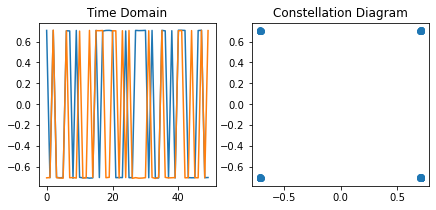

In [2]:
qpsk_symbols = generate_qpsk(50)
fig, ax = plt.subplots(1,2, figsize=(7,3))
ax[0].plot(qpsk_symbols.real)
ax[0].plot(qpsk_symbols.imag)
ax[1].plot(qpsk_symbols.real, qpsk_symbols.imag, 'o')
ax[0].set_title('Time Domain')
ax[1].set_title('Constellation Diagram')

Let's generate an example of each modulation scheme we will be working with. I've also upsampled these and pulse shaped them with a sinc filter (purely because it's easy to call np.sinc to make a filter in numpy, more realistic datasets will probably be using root raised cosine).

In [3]:
# Generate 50 samples of each modulation scheme, then upsample by 5 with a
# sinc pulse shaping filter
num_samples = 50
bpsk_symbols = pulse_shape(generate_bpsk(num_samples), sps=5)
qpsk_symbols = pulse_shape(generate_qpsk(num_samples), sps=5)
psk_symbols = pulse_shape(generate_psk8(num_samples), sps=5)
qam_symbols = pulse_shape(generate_qam(num_samples), sps=5)
ask_symbols = pulse_shape(generate_ask4(num_samples), sps=5)

# For plotting convenience just concat them into a single array
symbols = np.vstack((bpsk_symbols, qpsk_symbols, psk_symbols, qam_symbols, ask_symbols))

For the most part we can see the differences between modulation schemes even by eye, however this soon becomes not the case when adding noise and channel effects. Communications systems are frequently exposed to noise and interference, which lowers the Signal to Noise Ratio (SNR). A good AMC model will compensate for these and give a good estimate of what modulation schemes are being transmitted.

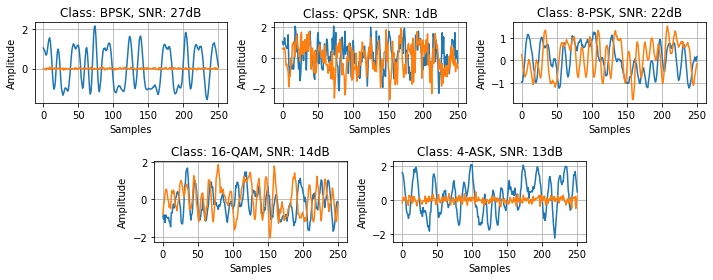

In [4]:
# Have a classes list for titles
classes = ['BPSK', 'QPSK', '8-PSK', '16-QAM', '4-ASK']

fig, ax = plt.subplots(6,4, figsize=(10,4))

ax[0] = plt.subplot2grid((2,6), (0,0), colspan=2)
ax[1] = plt.subplot2grid((2,6), (0,2), colspan=2)
ax[2] = plt.subplot2grid((2,6), (0,4), colspan=2)
ax[3] = plt.subplot2grid((2,6), (1,1), colspan=2)
ax[4] = plt.subplot2grid((2,6), (1,3), colspan=2)

idx = 0
for i, axis in enumerate(ax.ravel()):
    if i%4 == 0 and (i != 20):
        snr = np.random.randint(0,30)
        symbols[idx] = awgn(symbols[idx], snr)
        axis.plot(symbols[idx].real)
        axis.plot(symbols[idx].imag)
        axis.set_title(f"Class: {classes[idx]}, SNR: {snr}dB")
        axis.set_xlabel('Samples')
        axis.set_ylabel('Amplitude')
        axis.grid()
        idx += 1
        
plt.tight_layout()
plt.savefig('figures/amc_data.png', dpi=300, bbox_inches='tight')

A common way of classifying the time series data above is to engineer a set of features, which could distinguish the different modulation schemes. Here we define a function that will take the higher order moments of the instantaneous magnitude and phase, and produce a vector of 6 features. We can then use these features to train a machine learning model to select the best thresholds to recognize each modulation scheme.

In [5]:
def calculate_statistics(x):
    
    # Extract instantaneous amplitude and phase
    inst_a = np.abs(x) 
    inst_p = np.angle(x)

    # Amplitude statistics
    m2_a = np.mean((inst_a-np.mean(inst_a))**2) # variance of instantaneous amplitude
    m3_a = np.mean((inst_a-np.mean(inst_a))**3)/(m2_a**(3/2)) # skewness of amplitude
    m4_a = np.mean((inst_a-np.mean(inst_a))**4)/(m2_a**(2)) # kurtosis of amplitude
    
    # Phase statistics
    m2_p = np.mean((inst_p-np.mean(inst_p))**2) # variance of instantaneous phase
    m3_p = np.mean((inst_p-np.mean(inst_p))**3)/(m2_p**(3/2)) # skewness of phase
    m4_p = np.mean((inst_p-np.mean(inst_p))**4)/(m2_p**(2)) # kurtosis of phase
    
    return  m2_a, m3_a, m4_a, m2_p, m3_p, m4_p

Looking at the feature vectors for the different modulation schemes, we can definitely see that they are separable to some degree, which means we can use sets of these features as training data for an ML model. We could also do some Principle Component Analysis (PCA) or plot these in a 3d plane and see how these could be sliced up by some hyperplanes, proving validity of classification.

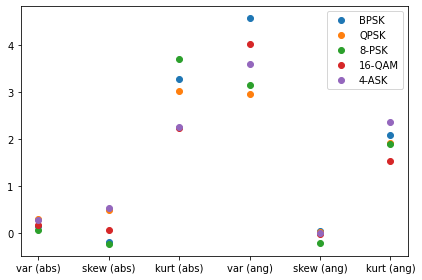

In [6]:
for i, mod in enumerate(classes):
    plt.plot(calculate_statistics(symbols[i]), 'o')
plt.xticks([0,1,2,3,4,5], ['var (abs)', 'skew (abs)', 'kurt (abs)', 'var (ang)', 'skew (ang)', 'kurt (ang)'])
plt.legend(classes)
plt.tight_layout()

A couple functions to help generate the training data. For each SNR level we create a number of frames, apply some Additive White Gaussian Noise (AWGN), normalize each frame by its mean power and calculate the 6 stastistical features which get concattenated into a single training array.

So, for example, the generated 32 frames of 128 samples per frame becomes 32 vectors of 6 features each.

In [7]:
# Function returns (num_frames,6) sized array of a single modulation scheme
# specified by mod_scheme string. Returned frames are pulse shaped and upsampled
# by a factor of sps
def gen_feature_data(mod_scheme, num_frames=32, samples_per_frame=128, sps=5, snr=30):
            
    # Calculate how many symbols (before upsampling) are needed for the required
    # samples_per_frame parameter
    symbols_required = int(np.ceil(samples_per_frame/sps))*num_frames
        
    # Mod scheme has to be one of: 'BPSK', 'QPSK', '8-PSK', '16-QAM' or '4-ASK'
    if mod_scheme == 'BPSK':
        symbols = pulse_shape(generate_bpsk(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == 'QPSK':
        symbols = pulse_shape(generate_qpsk(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '8-PSK':
        symbols = pulse_shape(generate_psk8(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '16-QAM':
        symbols = pulse_shape(generate_qam(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '4-ASK':
        symbols = pulse_shape(generate_ask4(symbols_required), sps=sps)[:num_frames*samples_per_frame]

    # Add noise and split into frames
    frames = awgn(symbols.reshape(num_frames,-1), snr)

    # Pre-allocate an array to hold the feature vecs
    feat_vec = np.zeros((len(frames), 6))
    
    # Normalize to unit energy per frame
    for i, frame in enumerate(frames):
        power = np.mean((np.abs(frame)))
        frames[i] = frame / power
        
        feat_vec[i] = calculate_statistics(frames[i])

    return feat_vec

# Function returns (num_frames*snr_range, 6) sized array, similarly to gen_feature_data,
# but passes through different SNR values first specified by snr_range list.
def gen_features_from_list(mod_scheme, snr_range, num_frames=32, samples_per_frame=128):
    
    # total dataset size
    feat_vec = np.zeros((num_frames*len(snr_range), 6), dtype=float)
    
    # for each snr value, generate num_frames worth of modulation examples
    for i, snr in enumerate(snr_range):
        feat_vec[i*num_frames:(i+1)*num_frames] = gen_feature_data(mod_scheme, num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
    
    return feat_vec

# Function returns dataset of 5 modulation schemes, at specified number of frames
# per each modulation scheme per snr level - **snr param must be a list**
def gen_dataset(num_frames=32, samples_per_frame=128, snr=[30], batch_size=32):
    
    bpsk_data = gen_features_from_list('BPSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    qpsk_data = gen_features_from_list('QPSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    psk_data = gen_features_from_list('8-PSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    qam_data = gen_features_from_list('16-QAM', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    ask_data = gen_features_from_list('4-ASK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    
    train_data = np.concatenate((bpsk_data, qpsk_data, psk_data, qam_data, ask_data))
    
    # Modulation labels
    bpsk_labels = np.zeros(bpsk_data.shape[0], dtype=int)
    qpsk_labels = np.ones(qpsk_data.shape[0], dtype=int)
    psk_labels = np.ones(psk_data.shape[0], dtype=int)*2
    qam_labels = np.ones(qam_data.shape[0], dtype=int)*3
    ask_labels = np.ones(ask_data.shape[0], dtype=int)*4

    train_labels = np.concatenate((bpsk_labels, qpsk_labels, psk_labels, qam_labels, ask_labels))
    
    return train_data, train_labels

The good thing about this approach is that regardless of the input size (be it 128 or 1024 samples), the number of statistics we are extracting in this case remains constant.

In [8]:
# test our function
x = gen_feature_data('BPSK', num_frames=32, samples_per_frame=128, sps=5, snr=30)
print('Data shape at 128 samples per frame: {}'.format(x.shape))

x = gen_feature_data('BPSK', num_frames=32, samples_per_frame=512, sps=5, snr=30)
print('Data shape at 512 samples per frame: {}'.format(x.shape))

Data shape at 128 samples per frame: (32, 6)
Data shape at 512 samples per frame: (32, 6)


We generate and extract features from 256 frames per modulation scheme per SNR level in a list of SNRs from 0 to 20 with increments of 2.

In [9]:
x_train, y_train = gen_dataset(num_frames=256, snr=np.arange(0,20,2))

The training dataset consists of feature vectors in x_train and labels (our desired outputs) as y_train. So, for every set of features we will have a label associated with it.

In [10]:
print(x_train.shape)
print(y_train.shape)

(12800, 6)
(12800,)


Note that labels are just integers corresponding to the classes, e.g. BPSK -> 0, QPSK -> 1. For decision trees we don't need to do any fance one-hot encoding or anything like that.

In [11]:
y_train

array([0, 0, 0, ..., 4, 4, 4])

## Training Decision Tree

We use the tree module from scikit-learn to create a simple decision tree classifier. This is one of the simplest ML models, however it is still a very powerful method, used widely, especially when dealing with tabular data - which technically is what we are doing as we are only passing 6 statistical values per observed frame, as opposed to feeding it every complex sample from our capture (this happens in deep learning).

We are going to limit the max depth because DTs are notorious for overfitting.

In [12]:
clf = tree.DecisionTreeClassifier(max_depth=5)

The simplicity of training a DT model shocked me, but it's true - just a single `fit` call on the DT object with our training data.

In [13]:
clf = clf.fit(x_train, y_train)

aaand it's done!

## Testing

### Test Over Range of SNRs

Now that the tree is trained, we can evaluate under a range of different SNRs. Looks like the overall accuracy saturates at around the 70% mark.

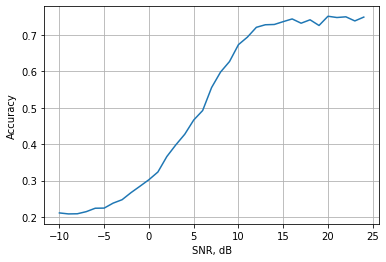

In [14]:
test_snr_range = np.arange(-10,25)
accuracies = []

for snr in test_snr_range:
    x_test, y_test = gen_dataset(num_frames=512, snr=[snr])
    y_hat = clf.predict(x_test)
    accuracies.append(np.mean(y_hat == y_test))
    
plt.plot(test_snr_range, accuracies)
plt.ylabel('Accuracy'); plt.xlabel('SNR, dB')
plt.grid()

We'll hang on to this baseline for later.

In [16]:
np.save('./baselines/ml_baseline', accuracies)

### Confusion Matrix

A useful way of visualizing the performance of any classifier is by confusion matrix. This gives a bit of a better insight as to what exactly is going wrong, and which classes we should focus on to improve performance.

Scikit-learn makes life a bit easier for us and has a confusion matrix function ready to go.

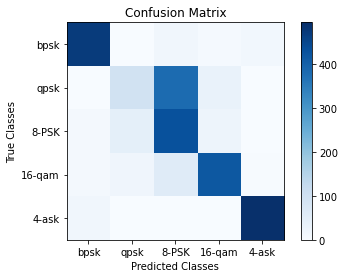

In [17]:
# Import confusion matrix function and use to get our cm
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_hat) # y_test, and y_hat come from latest test loop above

# Plot the confusion matrix, Blues cmap is probably most popular choice
plt.imshow(cm, cmap='Blues')
plt.xticks([0,1,2,3,4], ['bpsk', 'qpsk', '8-PSK', '16-qam', '4-ask'])
plt.yticks([0,1,2,3,4], ['bpsk', 'qpsk', '8-PSK', '16-qam', '4-ask'])
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.title('Confusion Matrix')
plt.colorbar()

From our confusion matrix we can tell that the problem area is gonna be the misclassification of QPSK, 16-QAM and 8-PSK classes, at least at high SNR. How do we solve it? Could add extra features that help in these particular cases, add more training data of just these classes, or try better models. 

To get a very rough estimate of what can be done though this is a good start.

## Bonus content

Another super neat thing about DTs in scikit-learn is you can actually visualize it! Interpretability definitely a strong suite of decision trees. 

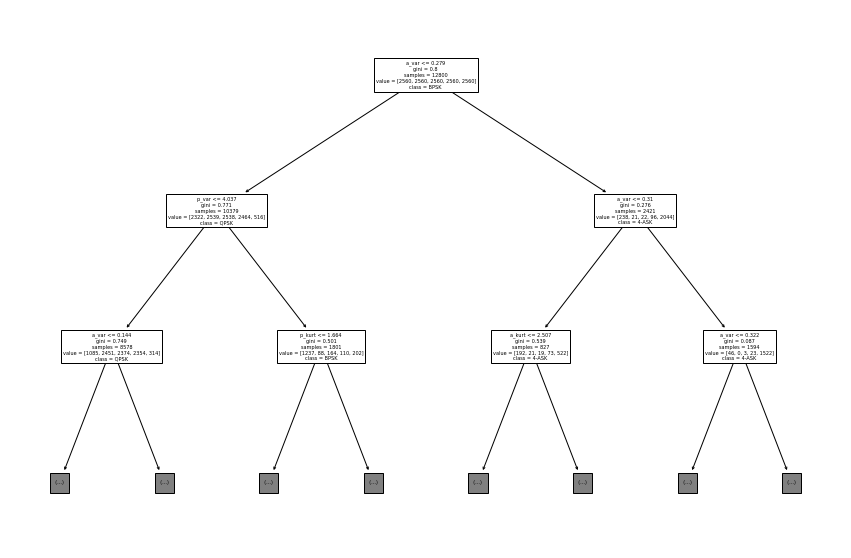

In [18]:
plt.figure(figsize=(15,10))
tree.plot_tree(clf, max_depth=2,  
               feature_names=['a_var', 'a_std', 'a_kurt', 'p_var', 'p_std', 'p_kurt'],  
               class_names=classes,)

plt.show()